In [1]:
# This is the notebook accompanying the statistic
# marginalized over the higher mode amplitudes as
# introduced in the paper arXiv: 2405.17400v1
# For any ambiguity or if you need any more info, please contact 
# jayw@ias.edu

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Change to your directory which has the data files
dire = "/Users/jayw/Downloads/"

# 1. Statistic for single detector collection

In [7]:
# This fn implements the marginalization score statistic given in Eq.A5 and A6 of arXiv: 2405.17400v1

def marginalized_HM_scores(
        triggers, Rij_samples, marginalized=True,
        single_det=True, N_det_effective=2):
    """
    The scores obtained from triggering can sometimes be unphysical
    ,e.g., |Z_33|>>|Z_22| (here Z=complex rho timeseries)
    This function marginalizes or maximizes over inclination and mass ratio for HMs
    :param triggers:
        array with ntriggers x [rho^\perp_22, rho^\perp_33, rho^\perp_44]
    :param marginalized: marginalizing instead of maximizing
    :param single_det: Boolean flag for multi-detector case
    :param N_det_effective: if single_det=True, how many times to multiply the
            likelihood in single det case by  corresponding to the likelihood
            expected from other detectors in an optimistic scenario.
    :return: if marginalized: return Z^2_marginalized (size: ntriggers)
                else: ntriggers x [Z22, Z33, Z44] array
                        where Z are complex overlaps corresponding
                        to max lnL physical sample
    """
    if triggers.ndim !=2:
        raise ValueError("code is only written for 2D inputs as of now")
    # In case there are too many triggers, loop to save memory
    if len(triggers) > int(1e4):
        num = int(len(triggers)//1e4 + 1)
        trig_batches = [marginalized_HM_scores(
            triggers[int(i*1e4):int((i+1)*1e4)], Rij_samples, marginalized,
                            single_det, N_det_effective) for i in range(num)]
        return(np.concatenate(trig_batches))

    Z = triggers[:,0::2] + 1j*triggers[:,1::2]


    r_33, r_44, weights_samples = Rij_samples.T.copy()

    # else:
    #     mode_ratios_samples = self.Norm_Flow_Rij_Triggering.generate_samples(
    #         calpha[..., :self.ndims])
    #     r_33, r_44, weights_samples = mode_ratios_samples.T
    
    weights_samples /= np.sum(weights_samples)
    
    likelihood_samples = np.zeros((len(r_33), len(Z)))
    z22, z33, z44 = np.abs(Z.T)

    # phase_term is either arg(z44) + arg(z22) - 2*arg(z33)
    # or 33 and 44 interchanged
    mask_44 = np.outer(r_33, z33) >= np.outer(r_44, z44)
    phase_term_44 = Z[:,2] * Z[:,0] / (Z[:,1]**2+1e-4)
    phase_term_33 = Z[:,1] * Z[:,0] / (Z[:,2]**2+1e-4)
    phase_term_44 /= abs(phase_term_44)
    phase_term_33 /= abs(phase_term_33)

    likelihood_samples[mask_44] = ( np.abs(z22 + np.outer(r_33, z33) \
                                + np.outer(r_44, z44*phase_term_44))**2)[mask_44]
    likelihood_samples[~mask_44] = (np.abs(z22 + np.outer(r_33, z33*phase_term_33) \
                                + np.outer(r_44, z44))**2)[~mask_44]
    likelihood_samples *= (1/2/(1 + r_33**2 + r_44**2))[:, np.newaxis]
                    
    if not marginalized: # i.e., max score across samples
        inds_max = np.argmax(likelihood_samples, axis=0)
        del likelihood_samples
        r_33 = r_33[inds_max]
        r_44 = r_44[inds_max]
        mask_44 = r_33*z33 >= r_44*z44
        Z_out = Z.T.copy()
        Z_out[:,mask_44] = (np.abs(z22 + z33*r_33 + z44*r_44*phase_term_44)\
                    * Z_out / np.abs(Z_out) * np.array(
                [np.ones_like(r_33), r_33, np.conj(phase_term_44)*r_44])\
                /(1 + r_33**2 + r_44**2))[:,mask_44]
        Z_out[:,~mask_44] = (np.abs(z22 + z33*r_33*phase_term_33 + z44*r_44)\
                    * Z_out / np.abs(Z_out) * np.array(
                [np.ones_like(r_33), np.conj(phase_term_33)*r_33, r_44])\
                /(1 + r_33**2 + r_44**2))[:,~mask_44]
        return Z_out.T
    
    if not single_det:
        # currently only implemented for n_triggers = 1
        likelihood_samples = np.sum(likelihood_samples, axis=-1)
        max_likelihood = np.amax(likelihood_samples)
        evidence =  max_likelihood + np.log(np.sum(
                                np.exp(likelihood_samples-max_likelihood) * weights_samples))
        return 2*evidence

    likelihood_samples *= N_det_effective
    max_likelihoods = np.amax(likelihood_samples, axis=0)
    evidence = 1/N_det_effective * (max_likelihoods + \
                np.log(np.dot(weights_samples, np.exp(likelihood_samples-max_likelihoods))))
    return 2*evidence

In [8]:
# Please download the file containing
# the input data corresponding to a particular file H-H1_GWOSC_O3a_4KHZ_R1-1250574336-4096.hdf5
# https://drive.google.com/file/d/1F-xjymLRnUcZWWNEHT51ne7TIPRYok1r/view?usp=sharing

input_data = np.load(os.path.join(dire,'Data_for_statistics.npz'))
rho_complex = input_data['rho_complex']
times = input_data['times']
Rij_samples = input_data['HM_amp_ratio_samples']

In [9]:
incoherent_scores = np.linalg.norm(rho_complex, axis=1)**2
scores_22 = np.linalg.norm(rho_complex[:,:2], axis=1)**2
marginalized_scores = marginalized_HM_scores(rho_complex, Rij_samples, marginalized=True, N_det_effective=2)
physical_scores = marginalized_HM_scores(rho_complex, Rij_samples, marginalized=False)
physical_scores = np.linalg.norm(physical_scores, axis=-1)**2

In [10]:
import scipy.stats as stats

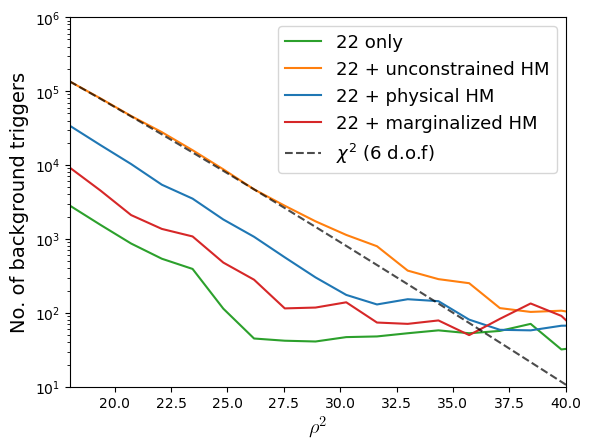

In [11]:
val0, bins = np.histogram(incoherent_scores, bins=100); 
bincent = 0.5 * (bins[1:] + bins[:-1])
val1,_ = np.histogram(scores_22, bins=bins)
val2,_ = np.histogram(physical_scores, bins=bins)
val3,_ = np.histogram(marginalized_scores, bins=bins)
plt.semilogy(bins[:-1],val1, label='22 only', color='C2')
plt.semilogy(bins[:-1],val0, label='22 + unconstrained HM', color='C1')
plt.semilogy(bins[:-1],val2, label='22 + physical HM', color='C0')
plt.semilogy(bins[:-1],val3, label='22 + marginalized HM', color='C3')
plt.plot(bins[:-1],stats.chi2.pdf(bincent,6)/stats.chi2.pdf(bincent[0],6)*val0[0], ls='--',
          color='k', alpha=0.7,label='$\chi^2$ (6 d.o.f)')
plt.ylabel('No. of background triggers', size=14); plt.xlabel(r'$\rho^2$',size=15,usetex=True);
# plt.xlim(left=25, right=50); plt.ylim(bottom=30, top=3e5);
plt.xlim(left=18, right=40); plt.ylim(bottom=10, top=1e6);
plt.legend(fontsize=13);

In [12]:
def splitarray(
        dat, splitvec, interval, axis=0, return_split_keys=False, origin=0):
    """
    Splits a single or multi-dimensional array into sub-arrays based on a
    coordinate
    :param dat:
        List/array to split (can be multidimensional, in which case it has to
        be a numpy array)
    :param splitvec: Numpy vector to split array dimension by
    :param interval: Length of buckets for values in splitvec
    :param axis:
        (>0) Axis to split dat along, dimension should match len(splitvec)
    :param return_split_keys:
        Flag indicating whether to return keys that we split according to
    :param origin: Split according to offsets from this origin
    :return:
        If return_split_keys is True,
        1. Keys split according to
        2. List of subarrays of dat split along axis according to values in
           splitvec every interval
        else, only the second one
    """
    isnp = type(dat) is np.ndarray
    if (axis > 0) and (not isnp):
        raise RuntimeError("Multidimensional arrays need to be numpy arrays")
    if (dat.shape[axis] if isnp else len(dat)) != len(splitvec):
        raise RuntimeError("Dimensions of array and splitvec do not match")
    if len(splitvec) == 0:
        raise RuntimeError("Cannot split according to an empty array!")
    splitvec = np.asarray(splitvec)

    # Sort according to splitvec
    if isnp:
        # Numpy array, create possibly multidimensional slice
        multislice = tuple(
            [slice(None)] * axis + [np.argsort(splitvec)] +
            [slice(None)] * (dat.ndim - axis - 1))
        dat = dat[multislice]
    else:
        # List
        dat = [dat[idx] for idx in np.argsort(splitvec)]

    # Find indices that split dimension into buckets every time_tol seconds
    splitvec = splitvec[np.argsort(splitvec)]

    # Check if we need to use floats for weird edge case that doesn't return
    # originals
    dtype_split = splitvec.dtype
    dtype_interval = type(interval)
    dtype_origin = type(origin)
    if (((dtype_split == np.dtype(int)) and (dtype_interval == np.dtype(int)))
            and (dtype_origin == np.dtype(int))):
        indarray = (splitvec - origin) // interval
    else:
        indarray = np.floor(((splitvec - origin) / interval)).astype(int)

    # Split data according to indices
    split_keys, split_indices = np.unique(indarray, return_index=True)
    dat_split = np.split(dat, split_indices[1:], axis=axis)

    if return_split_keys:
        return split_keys, dat_split
    else:
        return dat_split

In [13]:
binned = splitarray(rho_complex,times,interval=.01)
scores_binned = np.array([x[np.random.choice(len(x))] for x in binned])
Z_binned = scores_binned[:,0::2] + 1j*scores_binned[:,1::2]

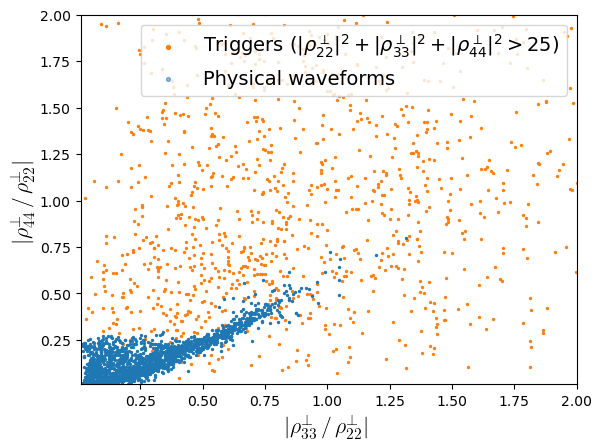

In [14]:
plt.scatter(np.abs(Z_binned[500:2000,1]/Z_binned[500:2000,0]),
             np.abs(Z_binned[500:2000,2]/Z_binned[500:2000,0]),s=2,color='C1', alpha=1)
plt.scatter(10,10,s=8,color='C1',label=r'Triggers ($|\rho^\perp_{22}|^2+|\rho^\perp_{33}|^2+|\rho^\perp_{44}|^2>25$)')
plt.scatter(Rij_samples[:,0], Rij_samples[:,1], s=2,color='C0')
plt.scatter(10,10,s=8,color='C0',label='Physical waveforms', alpha=0.5);
plt.legend(fontsize=14,loc=1);
plt.xlim(0.01,2);plt.ylim(0.01,2);
# plt.xscale('log'); plt.yscale('log');
plt.xlabel(r'$|\rho^\perp_{33}\, /\, \rho^\perp_{22}|$',size=16,usetex=True);
plt.ylabel(r'$|\rho^\perp_{44}\, /\, \rho^\perp_{22}|$',size=16, usetex=True);
# plt.savefig(plotdir+'trash.pdf', bbox_inches='tight');

# 2. Statistic for multi-detector collection

In [ ]:
# The code for finding coincident triggers in our pipeline is a bit involved
# So here we work with a simple simulation to demonstrate our multi-detector collection score

In [15]:
# In our pipeline, we use a cutoff on the marginalized single detector score for collecting
# single-detector triggers
ind_collected = marginalized_scores > 19
first_det_triggers = rho_complex[ind_collected]

In [16]:
# sample triggers without replacement for "simulating" the other detector
ind = np.random.choice(len(first_det_triggers), size=len(first_det_triggers), replace=False)
simulated_multi_det_triggers = np.c_[first_det_triggers, first_det_triggers[ind]]
simulated_multi_det_triggers = simulated_multi_det_triggers.reshape(-1,2,6)

In [17]:
multi_det_marg_scores = []
for i in range(len(scores_binned)):
    multi_det_marg_scores.append(marginalized_HM_scores(
        simulated_multi_det_triggers[i],
            Rij_samples=Rij_samples, single_det=False))
    
# This is the coherent score statistic in Eq.A6 of arXiv: 2405.17400v1

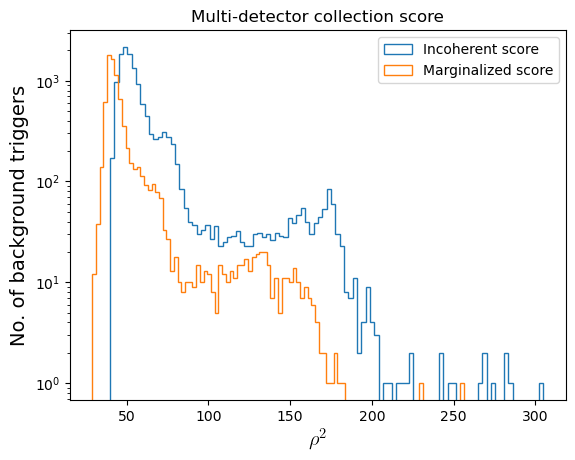

In [18]:
plt.hist(np.sum(np.sum(simulated_multi_det_triggers**2, axis=-1), axis=-1),
          log=True, bins=100, histtype='step', label='Incoherent score');
plt.hist(multi_det_marg_scores, log=True, bins=100, histtype='step',  label='Marginalized score');
plt.legend();
plt.ylabel('No. of background triggers', size=14); plt.xlabel(r'$\rho^2$',size=15,usetex=True)
plt.title('Multi-detector collection score');

In [ ]:
# Thus passing our coincident triggers to the multi-detector collection score
# we can further remove the triggers with unphysical higher mode amplitudes
# We place a cutoff on the multi-detector marginalized score
# and pass the remaining triggers to the following coherent score statistic
# which also considers coherence in the extrinsic parameters
# (time, phase, distance, inclination, polarization)

# The coherent score statistic is implemented in the code cogwheel
# and is a part of our final detection statistic

# 3. Statistics for HM marginalization along with extrinsic parameter coherence (e.g., time, phase, etc)

In [ ]:
# This section uses the coherent score statistic in Eq.21 of 2405.17400v1
# implemented from the code cogwheel
# See 2404.02435 and https://github.com/jroulet/cogwheel/blob/main/tutorials/extrinsic_marginalization.ipynb
# for further details on the marginalization over extrinsic parameters

In [19]:
import os, sys
# sys.path.insert(0,"/data/jayw/IAS/GW/gw_detection_ias") # or use dire
os.chdir(dire)
# Download coherent_score_hm_search.py and add it to the directory
import coherent_score_hm_search as cs
# This needs cogwheel to be installed: https://github.com/jroulet/cogwheel

import numpy as np
import matplotlib.pyplot as plt

/Users/jayw/miniconda3/envs/gw/lib/python3.10/site-packages/cogwheel/waveform.py:6: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [20]:
# Loading data from the IAS search pipeline for one of the GW events: GW190711_030756
# In case you want to generate the timeseries yourself for a different event,
# you could use the following tutorial from cogwheel:
# https://github.com/jroulet/cogwheel/blob/main/tutorials/extrinsic_marginalization.ipynb
inputs = np.load(dire+'/SNR_Timeseries_GW190711.npz')

# <data|model_waveform> with 3 dims: [mode, times, detectors] (Eq. 9)
dh_mtd = inputs['dh_mtd'];
# <model_waveform|model_waveform> with 3 dims: [mode, detectors] 
# (basically covariance matrix of the unorthogonalized modes) (Eq. 8)
hh_md=inputs['hh_md'];
# array of times
times = inputs['times'];
# sum of SNR^2 of modes (after orthogonalization of modes)
incoherent_lnprob_td=inputs['incoherent_lnprob_td'];

# R33, R44 values given in the Eq. 7
# In a future paper, we will release a code to calculate R33, R44
# for any arbitrary event
mode_ratios_qm=inputs['mode_ratios_qm'];
# array with time of H and L trigger
trigger_times=inputs['trigger_times']

In [21]:
detectors=('H1', 'L1')

# Hyperparameters for cogwheel marginalization integral
LOG2N_QMC, NPHI, MAX_LOG2N_QMC, MIN_N_EFFECTIVE = 12, 256, 16, 50

# Create a coherent score instance
cs_instance = cs.SearchCoherentScoreHMAS(
        sky_dict=cs.cogwheel.likelihood.marginalization.SkyDictionary(
                detectors[0][0]+detectors[1][0]),
        log2n_qmc=LOG2N_QMC, nphi=NPHI,
        max_log2n_qmc=MAX_LOG2N_QMC, n_qmc_sequences=100, seed=None)
cs_instance.min_n_effective = MIN_N_EFFECTIVE

# Create 100 different initial QMC sequences for marginalization integral
# (later, samples from each will be combined to give a better sampled posterior)
for i in range(len(cs_instance._qmc_sequences)):
    cs_instance._rng.random()
    cs_instance._qmc_sequences[i] = cs_instance._create_qmc_sequence()

# Calculating reference distance to SNR=1 template and rescaling
dist_factor_ref = cs_instance.lookup_table.d_luminosity_max\
                    /cs_instance.lookup_table.REFERENCE_DISTANCE

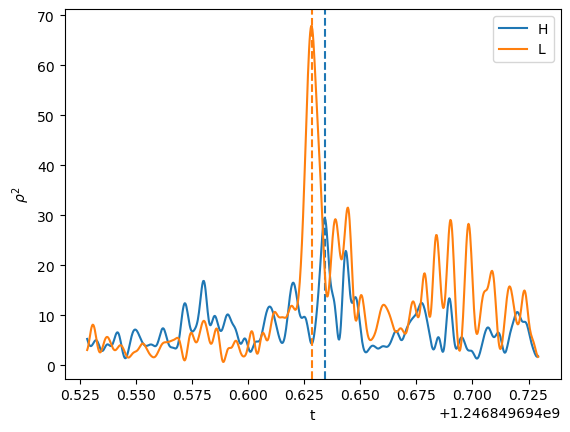

In [22]:
plt.figure()
plt.plot(times, 2*incoherent_lnprob_td[:,0], label='H'); plt.axvline(x=trigger_times[0], c='C0', ls='--')
plt.plot(times, 2*incoherent_lnprob_td[:,1],label='L'); plt.axvline(x=trigger_times[1], c='C1', ls='--')
# plt.axhline(y = np.max(2*incoherent_lnprob_td[:,1])-10)
plt.xlabel('t'); plt.ylabel(r'$\rho^2$'); plt.legend();

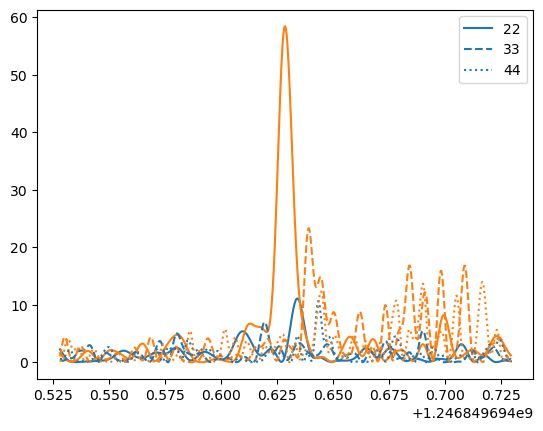

In [23]:
dh_mtd[:,:,0] /= dist_factor_ref
dh_mtd[:,:,1] /= dist_factor_ref
plt.plot(times,np.abs(dh_mtd[0])**2, label=['22',''])
plt.plot(times, (np.abs(dh_mtd[1])**2)[:,0], ls='--', color='C0', label='33')
plt.plot(times, (np.abs(dh_mtd[1])**2)[:,1], ls='--', color='C1')
plt.plot(times, (np.abs(dh_mtd[2])**2)[:,0], ls='dotted', color='C0', label='44')
plt.plot(times, (np.abs(dh_mtd[2])**2)[:,1], ls='dotted', color='C1')
plt.legend()
dh_mtd[:,:,0] *= dist_factor_ref
dh_mtd[:,:,1] *= dist_factor_ref
# plt.xlim(left=times[350], right=times[480])

# Again, blue is H, orange is L

In [24]:
# Generating samples from the marginalized integral

import pandas as pd
from cogwheel import gw_plotting
def _gen_samples_from_marg_info(self, marg_info, num): 
    """
    Generate requested number of extrinsic parameter samples.

    Parameters
    ----------
    marg_info: MarginalizationInfoHM
        Output of ``.get_marginalization_info``.

    num: int, optional
        Number of samples to generate, defaults to a single sample.

    Return
    ------
    samples: dict
        Values are scalar if `num` is ``None``, else numpy arrays.
        If ``marg_info`` correspond to an unphysical sample (i.e.,
        a realization of matched-filtering timeseries in the
        detectors incompatible with a real signal) the values will
        be NaN.
    """
    if marg_info.q_inds.size == 0:
        return dict.fromkeys(['d_luminosity', 'dec', 'lon', 'phi_ref',
                              'psi', 't_geocenter', 'lnl_marginalized',
                              'lnl', 'h_h', 'n_effective', 'n_qmc'],
                             np.full(num, np.nan)[()])

    random_ids = self._rng.choice(len(marg_info.q_inds), size=num,
                                  p=marg_info.weights)

    q_ids = marg_info.q_inds[random_ids]
    o_ids = marg_info.o_inds[random_ids]
    sky_ids = marg_info.sky_inds[random_ids]
    t_geocenter = (marg_info.t_first_det[random_ids]
                   - self.sky_dict.geocenter_delay_first_det[sky_ids])
    d_h = marg_info.d_h[random_ids]
    h_h = marg_info.h_h[random_ids]

    d_luminosity = self._sample_distance(d_h, h_h)
    distance_ratio = d_luminosity / self.lookup_table.REFERENCE_DISTANCE
    return {
        'd_luminosity': d_luminosity,
        'dec': self.sky_dict.sky_samples['lat'][sky_ids],
        'lon': self.sky_dict.sky_samples['lon'][sky_ids],
        'phi_ref': self._phi_ref[o_ids],
        'psi': self._qmc_sequence['psi'][q_ids],
        't_geocenter': t_geocenter,
        'lnl_marginalized': np.full(num, marg_info.lnl_marginalized)[()],
        'lnl': d_h / distance_ratio - h_h / distance_ratio**2 / 2,
        'h_h': h_h / distance_ratio**2,
        'n_effective': np.full(num, marg_info.n_effective)[()],
        'n_qmc': np.full(num, marg_info.n_qmc)[()],
        'cosiota': self._qmc_sequence['cosiota'][q_ids],
        }

In [25]:
# Making samples for 22+HM case
samples_list = []
for i in range(100):
    marg_info = cs_instance.get_marginalization_info(dh_mtd, hh_md,
                            times, incoherent_lnprob_td, mode_ratios_qm)
    samples_list.append(pd.DataFrame(_gen_samples_from_marg_info(cs_instance, marg_info, 100)))
samples = pd.concat(samples_list)
samples = pd.DataFrame(samples)

In [26]:
# Making samples for 22-only case by multiplying mode ratio prior by zero
samples_list = []
for i in range(100):
    marg_info = cs_instance.get_marginalization_info(dh_mtd, hh_md,
                            times, incoherent_lnprob_td, mode_ratios_qm*0)
    samples_list.append(pd.DataFrame(_gen_samples_from_marg_info(cs_instance, marg_info, 100)))
samples_QAS = pd.concat(samples_list)
samples_QAS = pd.DataFrame(samples_QAS)

In [27]:
params_samples = ['lon','dec',
 'd_luminosity',
 # 'psi',
 # 't_H','t_L', 'h_h','n_effective','lnl_marginalized',
'cosiota',
 'lnl']

# Currently d_luminosity is in normlized units (SNR=1 at 15 Gpc)
# To convert to physical units, multiply by the reference distance
# We will automate this in a future paper

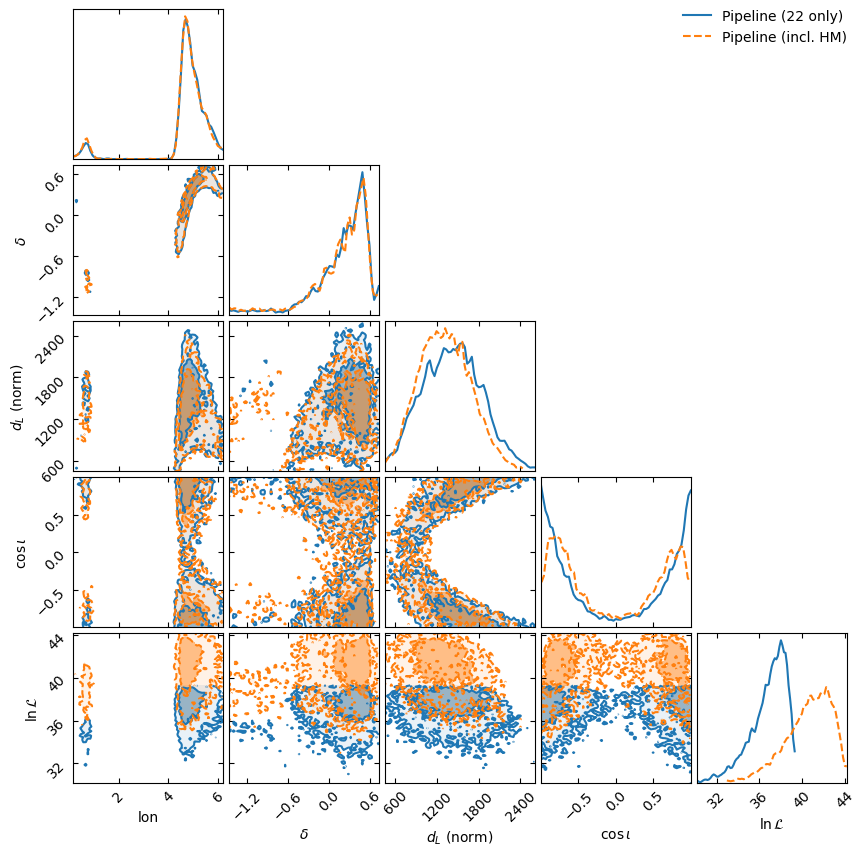

In [28]:
cp = gw_plotting.MultiCornerPlot((samples_QAS[params_samples],samples[params_samples]), tail_probability=1e-2,
                                  bins=64, labels=['Pipeline (22 only)','Pipeline (incl. HM)'])
cp.corner_plots[0].latex_labels.units['d_luminosity'] = 'norm'
cp.plot()

# To ensure that these give roughly unbiased results,
# we plan to compare these with a full PE run in a future paper

In [29]:
# Just for reference, the coherent score that we use as part of the ranking statistic
# in our search is calculated as:
cs_instance.lnlike_marginalized(dh_mtd, hh_md,
                    times, incoherent_lnprob_td, mode_ratios_qm)

19.692140829012146